In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
# Get TensorFlow Datasets
import tensorflow_datasets as tfds
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# List available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("cifar10" in datasets_list) # is the dataset we're after available?

True


In [4]:
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data, valid_data), ds_info = tfds.load(name="cifar10", # target dataset to get from TFDS
                                             split=["train[:90%]", "test", "train[90%:]"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [5]:
print("Train set size: ", len(train_data)) 
print("Test set size: ", len(test_data))  
print("Valid set size: ", len(valid_data)) 

Train set size:  45000
Test set size:  10000
Valid set size:  5000


In [6]:
class_names = ds_info.features["label"].names
class_names[:10]

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_data_sample = train_data.take(1)

In [8]:
for image, label in train_data_sample:
  print(f"""
  Image Shape: {image.shape},
  Image dtype: {image.dtype},
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label]}
  """)


  Image Shape: (32, 32, 3),
  Image dtype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 7
  Class name (str form): horse
  


(-0.5, 31.5, 31.5, -0.5)

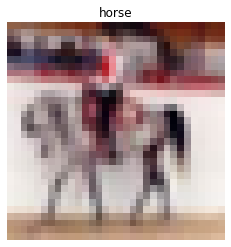

In [9]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[int(label)]) # add title to image by indexing on class_names list
plt.axis(False)

In [10]:
def input_preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    image = tf.keras.applications.resnet50.preprocess_input(image)
    #image = image/255.
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [11]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

valid_data = valid_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
valid_data = valid_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [13]:
# Create base model
input_shape = (224, 224, 3)
input_t = tf.keras.Input(shape=(224,224,3))
res_model = tf.keras.applications.ResNet50(include_top=False,
                                              weights='imagenet',
                                              input_tensor=input_t)

res_model.trainable = False # freeze base model layers

for layer in res_model.layers[:143]:
        layer.trainable = False

In [14]:
# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = res_model(inputs, training=False) # set base_model to inference mode only
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile our resnet model
model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", # watch the val loss metric
                                                  patience=10,
                                                  min_delta=0.0001,) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")



In [15]:
# Fit the model
resnet_history=model.fit(train_data,
                         epochs=5, 
                         validation_data=valid_data,
                         callbacks=[model_checkpoint, # save only the best model during training
                                    early_stopping, # stop model after X epochs of no improvements
                                    reduce_lr])

Epoch 1/5
1407/1407 [==============================] - ETA: 0s - loss: 1.4578 - accuracy: 0.5196INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 253s 174ms/step - loss: 1.4578 - accuracy: 0.5196 - val_loss: 0.4663 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 2/5
1407/1407 [==============================] - ETA: 0s - loss: 0.8673 - accuracy: 0.7353INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 250s 177ms/step - loss: 0.8673 - accuracy: 0.7353 - val_loss: 0.3307 - val_accuracy: 0.9106 - lr: 1.0000e-04
Epoch 3/5
1407/1407 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.8050INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 249s 177ms/step - loss: 0.6624 - accuracy: 0.8050 - val_loss: 0.2823 - val_accuracy: 0.9150 - lr: 1.0000e-04
Epoch 4/5
1407/1407 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.8398INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 247s 175ms/step - loss: 0.5520 - accuracy: 0.8398 - val_loss: 0.2566 - val_accuracy: 0.9182 - lr: 1.0000e-04
Epoch 5/5
1407/1407 [==============================] - ETA: 0s - loss: 0.4669 - accuracy: 0.8654INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 248s 175ms/step - loss: 0.4669 - accuracy: 0.8654 - val_loss: 0.2458 - val_accuracy: 0.9198 - lr: 1.0000e-04


In [16]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """ 
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

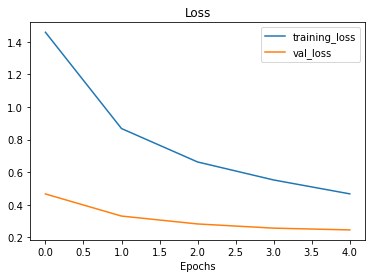

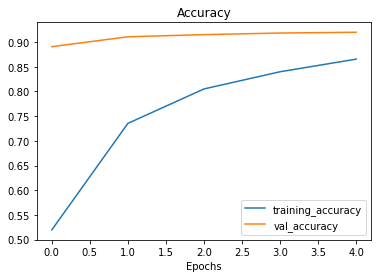

In [17]:
plot_loss_curves(resnet_history)

In [18]:
save_dir = "Cifar10_Resnet50/"

# # Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: Cifar10_Resnet50/assets


INFO:tensorflow:Assets written to: Cifar10_Resnet50/assets


In [19]:
# Evaluate model on whole test dataset
Cifar10_extract_model = model.evaluate(test_data)
Cifar10_extract_model

313/313 [==============================] - 41s 131ms/step - loss: 0.2638 - accuracy: 0.9160


[0.2637881934642792, 0.9160000085830688]

In [20]:
#model = tf.keras.models.load_model("Cifar10_Resnet50")

In [21]:
# Evaluate model on whole test dataset
#CheckpointCifar10_extract_model = model.evaluate(test_data)
#CheckpointCifar10_extract_model

In [22]:
res_model.trainable = True # freeze base model layers

for layer in res_model.layers[:-10]:
        layer.trainable = False

In [23]:
# Compile our resnet model
model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=["accuracy"])
# Fit the model
Checkpoint_resnet_history=model.fit(train_data,
                         epochs=12, 
                         validation_data=valid_data,
                         callbacks=[model_checkpoint, # save only the best model during training
                                    early_stopping, # stop model after X epochs of no improvements
                                    reduce_lr],
                         initial_epoch=resnet_history.epoch[-1])


Epoch 5/12
1407/1407 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.8769INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 267s 186ms/step - loss: 0.4302 - accuracy: 0.8769 - val_loss: 0.2357 - val_accuracy: 0.9210 - lr: 1.0000e-04
Epoch 6/12
1407/1407 [==============================] - 244s 173ms/step - loss: 0.3393 - accuracy: 0.9036 - val_loss: 0.2473 - val_accuracy: 0.9230 - lr: 1.0000e-04
Epoch 7/12
1407/1407 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9180
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1407/1407 [==============================] - 244s 173ms/step - loss: 0.2912 - accuracy: 0.9180 - val_loss: 0.2392 - val_accuracy: 0.9234 - lr: 1.0000e-04
Epoch 8/12
1407/1407 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9404INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 261s 185ms/step - loss: 0.2219 - accuracy: 0.9404 - val_loss: 0.2214 - val_accuracy: 0.9310 - lr: 2.0000e-05
Epoch 9/12
1407/1407 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9485INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


1407/1407 [==============================] - 262s 186ms/step - loss: 0.1952 - accuracy: 0.9485 - val_loss: 0.2180 - val_accuracy: 0.9346 - lr: 2.0000e-05
Epoch 10/12
1407/1407 [==============================] - 249s 177ms/step - loss: 0.1762 - accuracy: 0.9561 - val_loss: 0.2223 - val_accuracy: 0.9354 - lr: 2.0000e-05
Epoch 11/12
1407/1407 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9607
Epoch 11: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1407/1407 [==============================] - 247s 175ms/step - loss: 0.1596 - accuracy: 0.9607 - val_loss: 0.2248 - val_accuracy: 0.9346 - lr: 2.0000e-05
Epoch 12/12
1407/1407 [==============================] - 247s 175ms/step - loss: 0.1492 - accuracy: 0.9624 - val_loss: 0.2225 - val_accuracy: 0.9364 - lr: 4.0000e-06


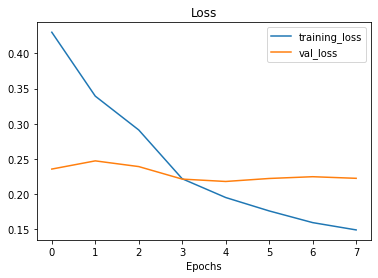

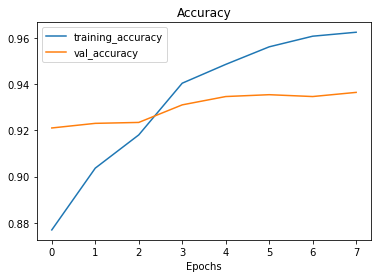

In [24]:
plot_loss_curves(Checkpoint_resnet_history)

In [25]:
# Evaluate model on whole test dataset
results_feature_extract_model2 = model.evaluate(test_data)
results_feature_extract_model2

313/313 [==============================] - 40s 126ms/step - loss: 0.2468 - accuracy: 0.9296


[0.24681423604488373, 0.9296000003814697]